<a href="https://colab.research.google.com/github/Al-Ahdal/Deep-learning-ML-and-tensorflow/blob/master/heart_Disease_Predictions_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cardio.csv to cardio (1).csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data = pd.read_csv('/content/cardio.csv', sep=";")
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0000,100,60,1,1,0,0,0,0


In [ ]:
# FE - thanks to: https://www.kaggle.com/benanakca/comparison-of-classification-disease-prediction
data.drop("id",axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_filter = ((data["ap_hi"]>250) | (data["ap_lo"]>200))
data = data[~out_filter]
len(data)



68983

In [ ]:
data['age'] = (data['age']/365).round().astype('int')

In [ ]:
out_filter2 = ((data["ap_hi"] < 0) | (data["ap_lo"] < 0))
data = data[~out_filter2]

In [ ]:
data.cardio.value_counts()

0    34836
1    34139
Name: cardio, dtype: int64

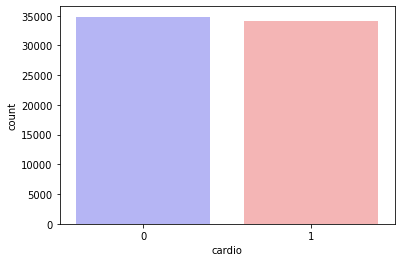

In [ ]:

sns.countplot(x="cardio", data=data, palette="bwr")
plt.show()

In [ ]:
countNoDisease = len(data[data.cardio == 0])
countHaveDisease = len(data[data.cardio == 1])
print("Percentage of Patients Haven't Heart Disease: {:.2f}%".format((countNoDisease / (len(data.cardio))*100)))
print("Percentage of Patients Have Heart Disease: {:.2f}%".format((countHaveDisease / (len(data.cardio))*100)))

Percentage of Patients Haven't Heart Disease: 50.51%
Percentage of Patients Have Heart Disease: 49.49%


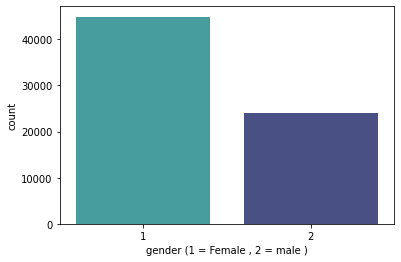

In [ ]:
sns.countplot(x='gender', data=data, palette="mako_r")
plt.xlabel("gender (1 = Female , 2 = male )")
plt.show()

In [ ]:
countFemale = len(data[data.gender == 1])
countMale = len(data[data.gender == 2])
print("Percentage of Female Patients: {:.2f}%".format((countFemale / (len(data.gender))*100)))
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(data.gender))*100)))

Percentage of Female Patients: 65.12%
Percentage of Male Patients: 34.88%


In [ ]:
data.groupby('cardio').mean()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
cardio,,,,,,,,,,,,
0,51.7214,1.3453,164.4445,71.5691,119.2873,78.1198,1.2158,1.1751,0.0925,0.0554,0.8179,26.5410
1,54.9618,1.3524,164.2731,76.7259,133.5060,84.6150,1.5163,1.2778,0.0832,0.0518,0.7883,28.5304


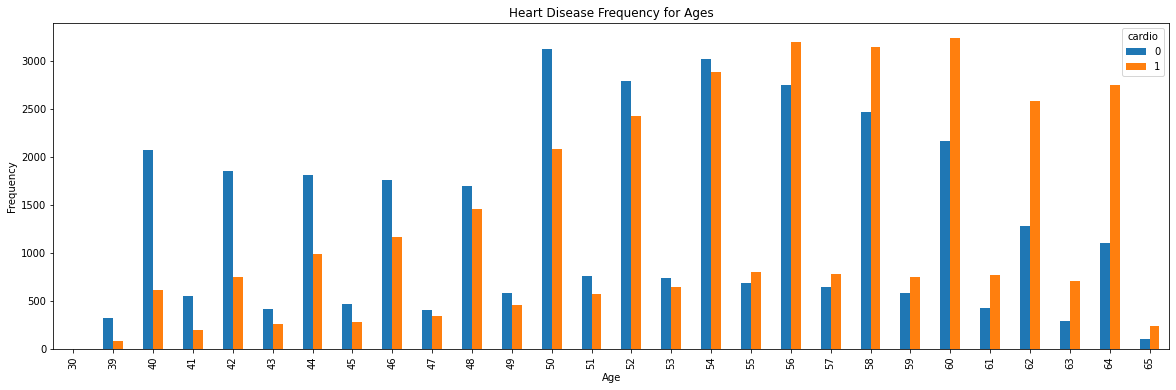

In [ ]:
pd.crosstab(data.age,data.cardio).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

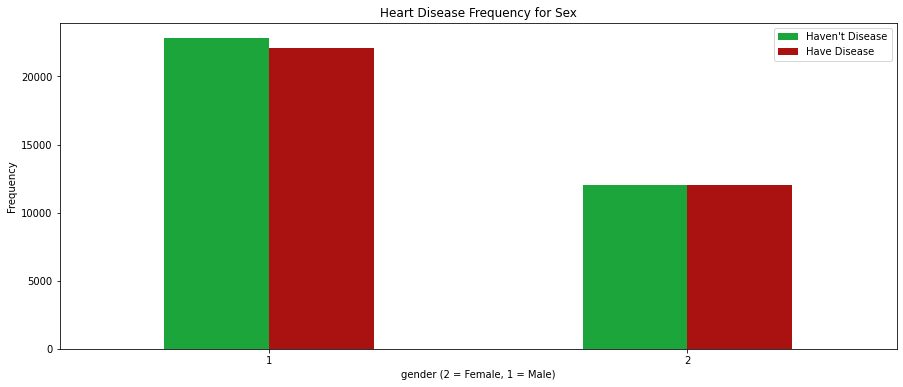

In [ ]:
pd.crosstab(data.gender,data.cardio).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('gender (2 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

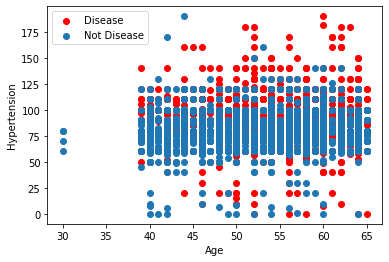

In [ ]:
#(prehypertension) systolic: 120–139 mm Hg diastolic: 80–89 mm Hg (" High Blood Pressure (hypertension)	systolic: 140 mm Hg or higher diastolic: 90 mm Hg or higher")
plt.scatter(x=data.age[data.cardio==1], y=data.ap_lo[(data.cardio==1)], c="red")
plt.scatter(x=data.age[data.cardio==0], y=data.ap_lo[(data.cardio==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Hypertension")
plt.show()

In [ ]:
pd.options.display.float_format='{:,.4f}'.format
corr_matrix=data.corr()
corr_matrix

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
age,1.0000,-0.0232,-0.0807,0.0551,0.1980,0.1510,0.1554,0.0990,-0.0480,-0.0292,-0.0103,0.2394,0.0862
gender,-0.0232,1.0000,0.4981,0.1559,0.0582,0.0647,-0.0368,-0.0210,0.3387,0.1710,0.0056,0.0075,-0.0960
height,-0.0807,0.4981,1.0000,0.2915,0.0176,0.0359,-0.0505,-0.0185,0.1880,0.0945,-0.0073,-0.0104,-0.2923
weight,0.0551,0.1559,0.2915,1.0000,0.2551,0.2453,0.1406,0.1068,0.0667,0.0679,-0.0180,0.1799,0.7595
ap_hi,0.1980,0.0582,0.0176,0.2551,1.0000,0.6463,0.1863,0.0879,0.0280,0.0315,0.0007,0.4014,0.2169
ap_lo,0.1510,0.0647,0.0359,0.2453,0.6463,1.0000,0.1554,0.0760,0.0246,0.0429,-0.0009,0.3289,0.2001
cholesterol,0.1554,-0.0368,-0.0505,0.1406,0.1863,0.1554,1.0000,0.4508,0.0098,0.0356,0.0090,0.2214,0.1450
gluc,0.0990,-0.0210,-0.0185,0.1068,0.0879,0.0760,0.4508,1.0000,-0.0057,0.0112,-0.0077,0.0897,0.1010
smoke,-0.0480,0.3387,0.1880,0.0667,0.0280,0.0246,0.0098,-0.0057,1.0000,0.3403,0.0257,-0.0164,-0.0282
alco,-0.0292,0.1710,0.0945,0.0679,0.0315,0.0429,0.0356,0.0112,0.3403,1.0000,0.0253,-0.0082,0.0148


In [ ]:
corr_matrix['height'].sort_values(ascending=False)

height         1.0000
gender         0.4981
weight         0.2915
smoke          0.1880
alco           0.0945
ap_lo          0.0359
ap_hi          0.0176
active        -0.0073
cardio        -0.0104
gluc          -0.0185
cholesterol   -0.0505
age           -0.0807
bmi           -0.2923
Name: height, dtype: float64

In [ ]:
data = data.drop('height', axis=1)

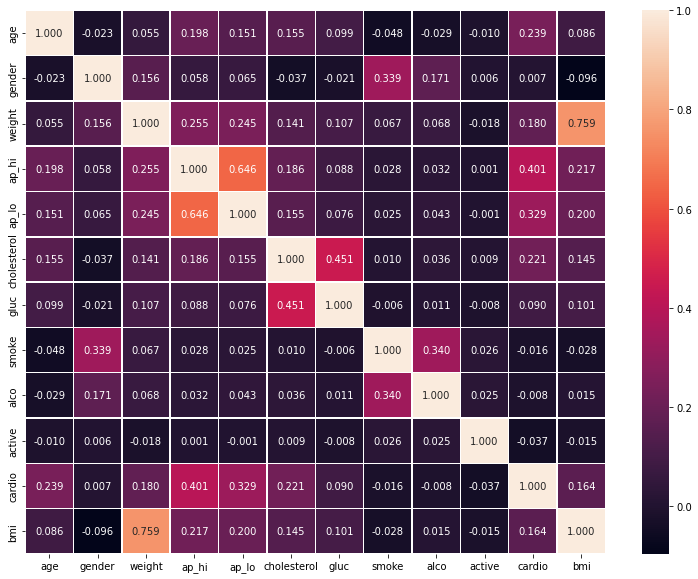

In [ ]:
import os
import seaborn as sns
corr = data.corr() 
f, ax = plt.subplots(figsize = (13,10))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

In [ ]:
data.head(3)

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,62.0000,110,80,1,1,0,0,1,0,21.9671
1,55,1,85.0000,140,90,3,1,0,0,1,1,34.9277
2,52,1,64.0000,130,70,3,1,0,0,0,1,23.5078


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68975 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68975 non-null  int64  
 1   gender       68975 non-null  int64  
 2   weight       68975 non-null  float64
 3   ap_hi        68975 non-null  int64  
 4   ap_lo        68975 non-null  int64  
 5   cholesterol  68975 non-null  int64  
 6   gluc         68975 non-null  int64  
 7   smoke        68975 non-null  int64  
 8   alco         68975 non-null  int64  
 9   active       68975 non-null  int64  
 10  cardio       68975 non-null  int64  
 11  bmi          68975 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 8.9 MB


In [ ]:
data.isnull().values.sum()

0

In [ ]:
data.describe()

,age,gender,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,"68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000","68,975.0000"
mean,53.3252,1.3488,74.1214,126.3248,81.3346,1.3645,1.2259,0.0879,0.0536,0.8033,0.4949,27.5257
std,6.7683,0.4766,14.3299,17.7109,9.8745,0.6788,0.5719,0.2832,0.2253,0.3975,0.5000,6.0814
min,30.0000,1.0000,11.0000,7.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,3.4718
25%,48.0000,1.0000,65.0000,120.0000,80.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,23.8751
50%,54.0000,1.0000,72.0000,120.0000,80.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,26.3465
75%,58.0000,2.0000,82.0000,140.0000,90.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,30.1194
max,65.0000,2.0000,200.0000,240.0000,190.0000,3.0000,3.0000,1.0000,1.0000,1.0000,1.0000,298.6667


In [ ]:
#print(data.columns)
for var in ['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi']:
       print(data[var].value_counts()/np.float(len(data)))
       print()


56   0.0860
54   0.0856
58   0.0812
60   0.0782
52   0.0756
50   0.0754
62   0.0560
64   0.0558
48   0.0457
46   0.0423
44   0.0406
40   0.0389
42   0.0377
55   0.0215
57   0.0207
53   0.0201
59   0.0193
51   0.0193
61   0.0174
49   0.0151
63   0.0145
41   0.0109
45   0.0108
47   0.0108
43   0.0098
39   0.0059
65   0.0050
30   0.0001
Name: age, dtype: float64

1   0.6512
2   0.3488
Name: gender, dtype: float64

65.0000    0.0552
70.0000    0.0539
68.0000    0.0406
75.0000    0.0392
60.0000    0.0389
            ...  
90.7000    0.0000
121.3000   0.0000
163.0000   0.0000
64.1000    0.0000
99.9000    0.0000
Name: weight, Length: 281, dtype: float64

120   0.4009
140   0.1353
130   0.1293
110   0.1253
150   0.0610
       ...  
60    0.0000
93    0.0000
197   0.0000
184   0.0000
187   0.0000
Name: ap_hi, Length: 119, dtype: float64

80    0.5046
90    0.2074
70    0.1485
100   0.0592
60    0.0395
       ...  
122   0.0000
135   0.0000
15    0.0000
54    0.0000
182   0.0000
Name: ap_lo, Len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


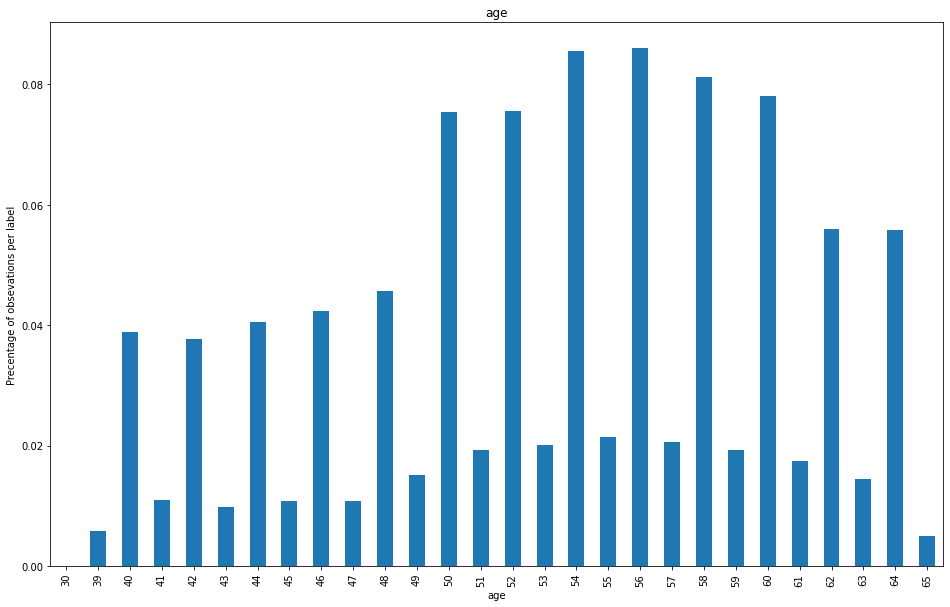

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


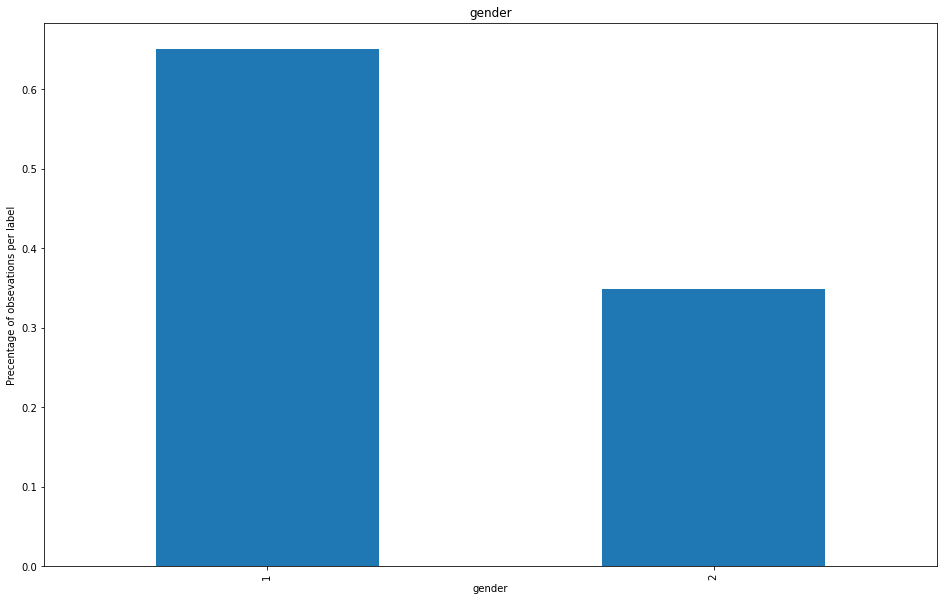

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


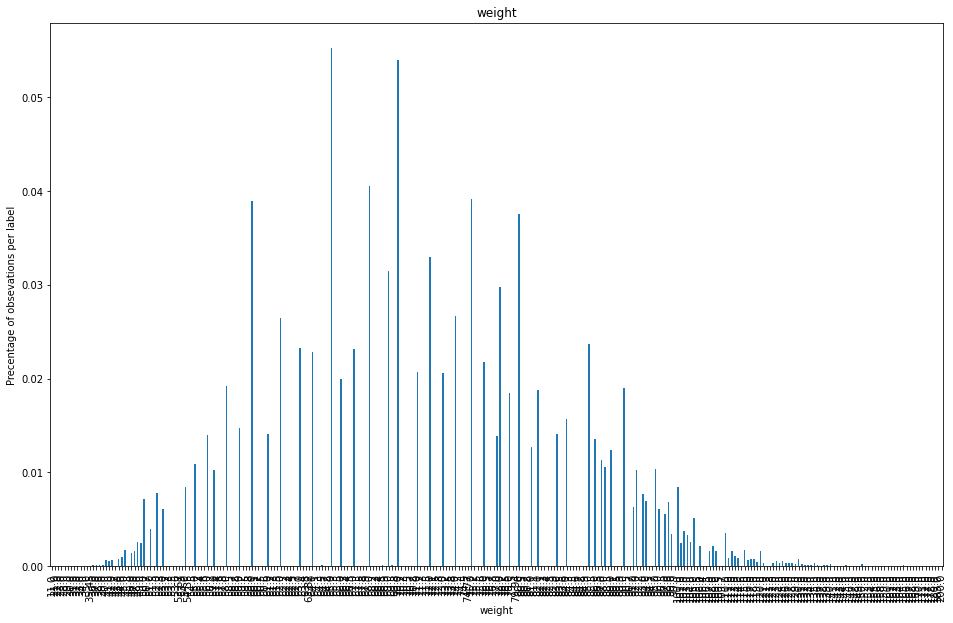

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


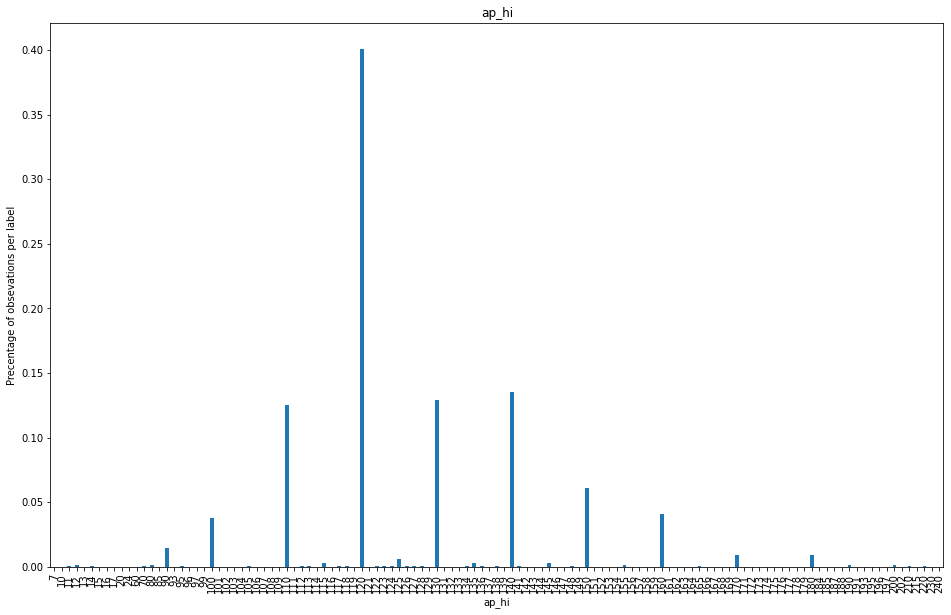

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


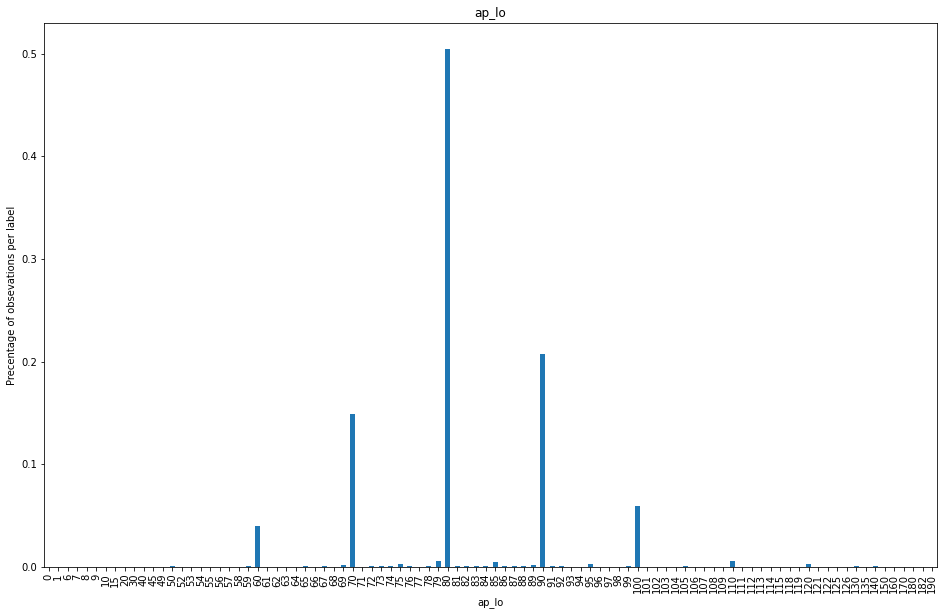

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


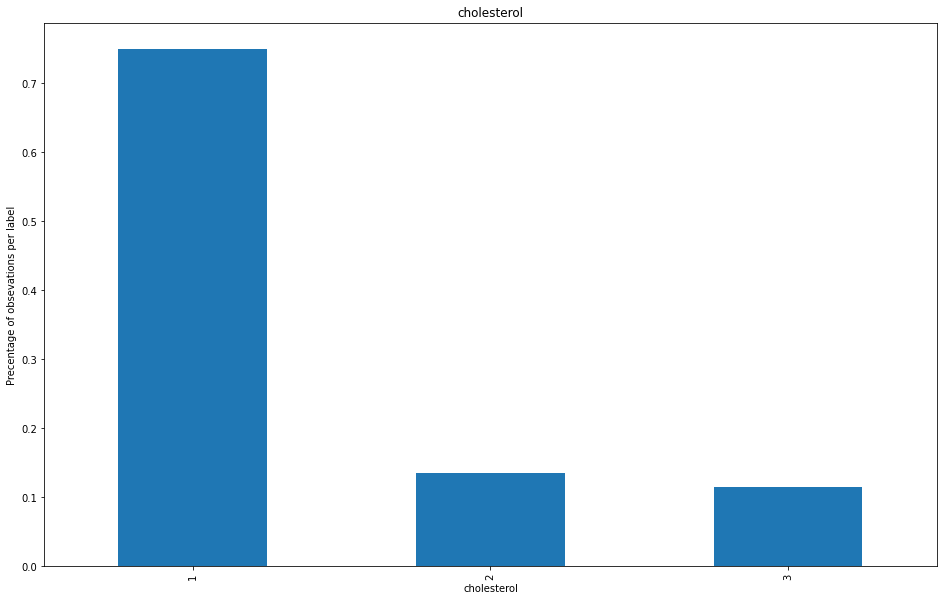

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


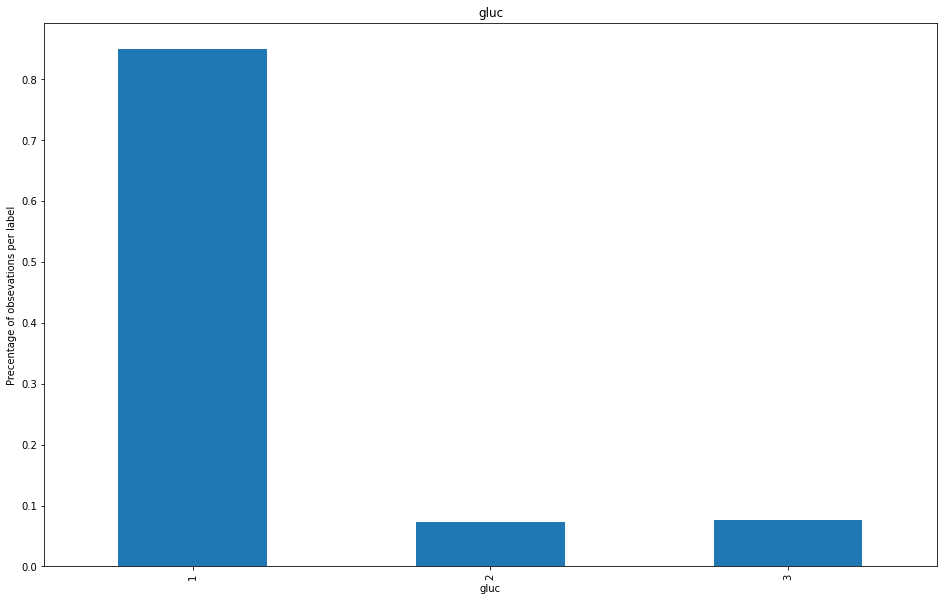

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


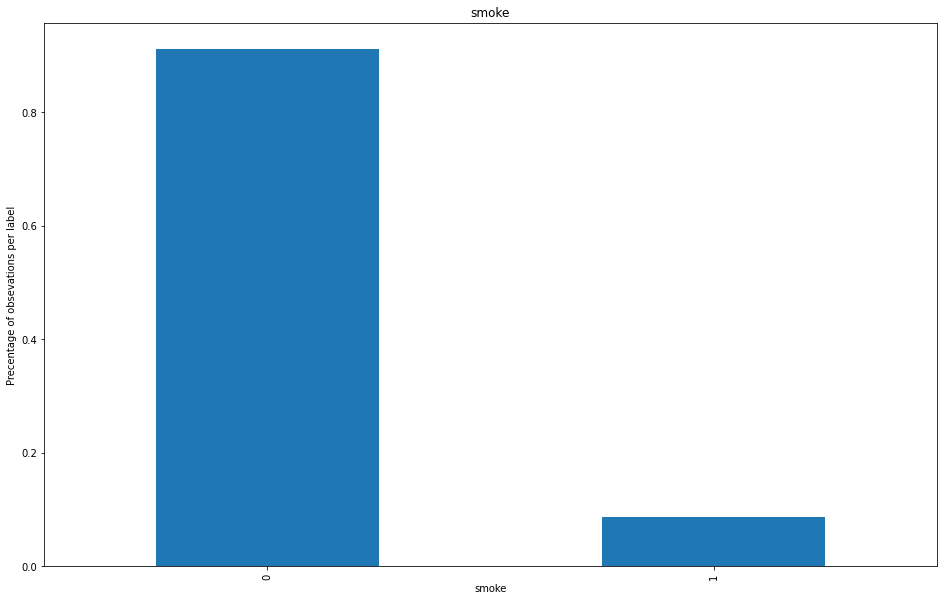

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


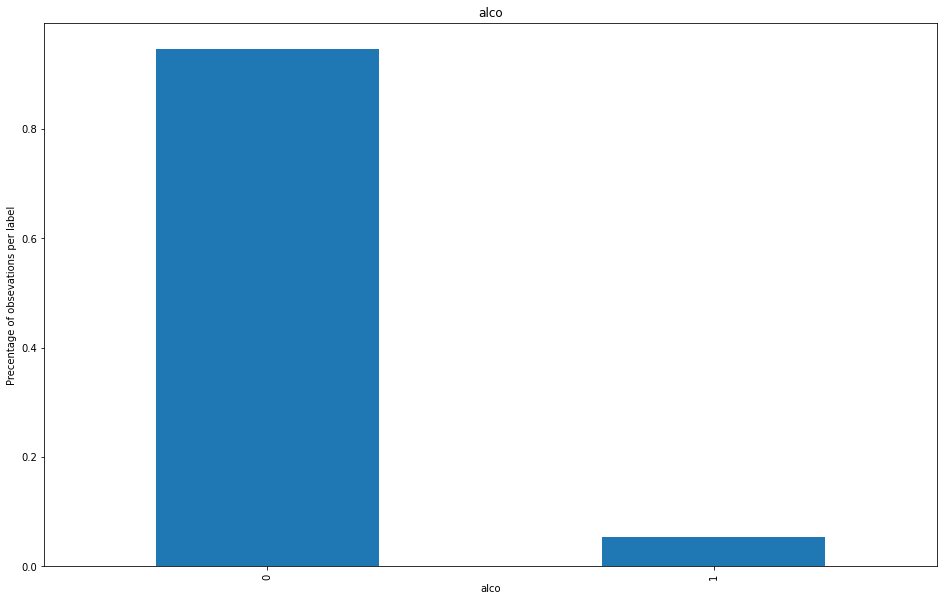

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


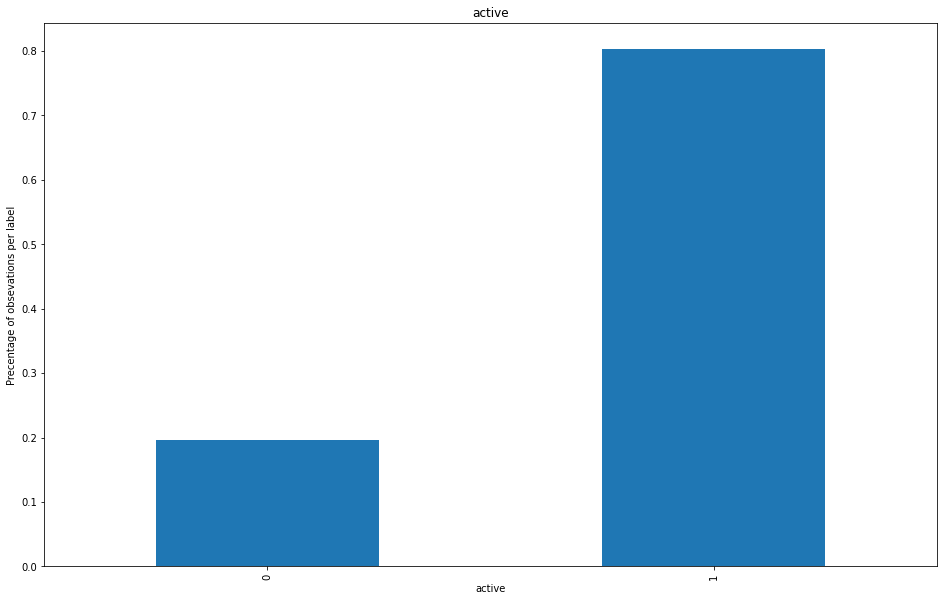

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


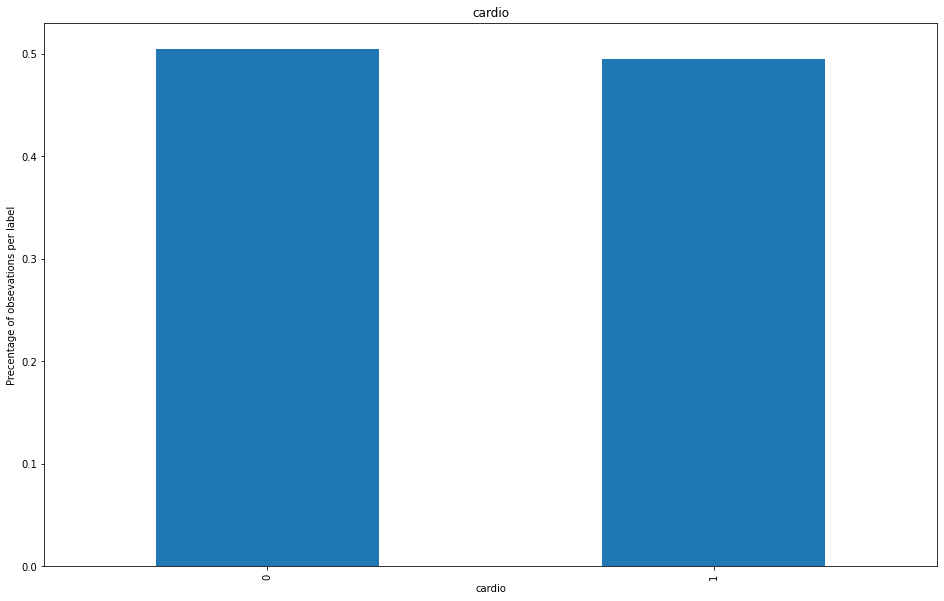

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


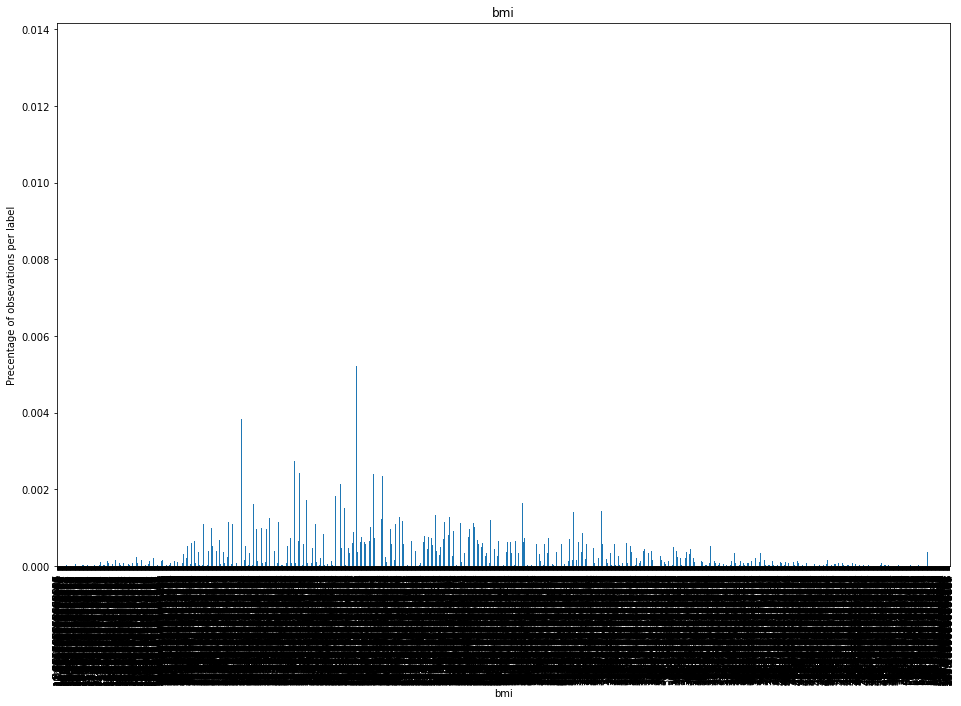

In [ ]:
for var in ['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi']:
       plt.figure (figsize=(16,10))
       (data.groupby(var)[var].count()/np.float(len(data))).plot.bar()
       plt.ylabel('Precentage of obsevations per label')
       plt.title(var)
       plt.show()

In [ ]:
categorical_val = []
continous_val = []
for column in data.columns:
    if len(data[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

In [ ]:
categorical_val

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

In [ ]:
categorical_val.remove('cardio')
dataset = pd.get_dummies(data, columns = categorical_val)

In [ ]:
dataset.head()

,age,weight,ap_hi,ap_lo,cardio,bmi,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,50,62.0000,110,80,0,21.9671,0,1,1,0,0,1,0,0,1,0,1,0,0,1
1,55,85.0000,140,90,1,34.9277,1,0,0,0,1,1,0,0,1,0,1,0,0,1
2,52,64.0000,130,70,1,23.5078,1,0,0,0,1,1,0,0,1,0,1,0,1,0
3,48,82.0000,150,100,1,28.7105,0,1,1,0,0,1,0,0,1,0,1,0,0,1
4,48,56.0000,100,60,0,23.0112,1,0,1,0,0,1,0,0,1,0,1,0,1,0


In [ ]:
print(data.columns)
print(dataset.columns)

Index(['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active', 'cardio', 'bmi'],
      dtype='object')
Index(['age', 'weight', 'ap_hi', 'ap_lo', 'cardio', 'bmi', 'gender_1',
       'gender_2', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'gluc_1',
       'gluc_2', 'gluc_3', 'smoke_0', 'smoke_1', 'alco_0', 'alco_1',
       'active_0', 'active_1'],
      dtype='object')


In [ ]:
#X = data.drop('cardio', axis=1)
#y = data.cardio
#print("Shape of X is :", X.shape, "Shape of y is :", y.shape)

In [ ]:
target_name = 'cardio'
data_target = data[target_name]
data = data.drop([target_name], axis=1)

In [ ]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset.drop('cardio', axis=1)
y = dataset.cardio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from collections import Counter
import pandas_profiling as pp
print( target_test.unique())
Counter( target)

[1 0]


Counter({0: 24467, 1: 23815})

In [ ]:
#Before applying algorithm we should check whether the data is equally splitted or not, because if data is not splitted equally it will cause for data imbalacing problem
print(target_test.unique())
Counter( target)

[1 0]


Counter({0: 24467, 1: 23815})

In [ ]:
train.head(3)
test.head(3)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48282 entries, 40004 to 69281
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          48282 non-null  int64  
 1   gender       48282 non-null  int64  
 2   weight       48282 non-null  float64
 3   ap_hi        48282 non-null  int64  
 4   ap_lo        48282 non-null  int64  
 5   cholesterol  48282 non-null  int64  
 6   gluc         48282 non-null  int64  
 7   smoke        48282 non-null  int64  
 8   alco         48282 non-null  int64  
 9   active       48282 non-null  int64  
 10  bmi          48282 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 4.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20693 entries, 51756 to 65008
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          20693 non-null  int64  
 1   gender       20693 non-null  int64  
 2   weigh

In [ ]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.3, random_state=0)

In [ ]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log
acc_test_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_test_log
#print_score(acc_log, X_train, y_train, X_test, y_test=True)
#print_score(acc_log, X_train, y_train, X_test, y_test#=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


72.54

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
print('train',acc_log)
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
print ('test',acc_test_log)


train 70.15
test 70.65


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
5,gluc,0.5403
7,alco,0.4338
1,weight,0.1733
3,ap_lo,0.0539
0,gender,0.0292
4,cholesterol,-0.0076
2,ap_hi,-0.0107
8,active,-0.1018
6,smoke,-0.1508
9,bmi,-1.1133


In [ ]:
# k-Nearest Neighbors algorithm

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3]}, cv=10).fit(train, target)
acc_knn = round(knn.score(train, target) * 100, 2)
print(acc_knn, knn.best_params_)
acc_test_knn = round(knn.score(test, target_test) * 100, 2)
print('test',acc_test_knn)

81.22 {'n_neighbors': 3}
test 67.12


In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
print('train',acc_gaussian)
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
print('test',acc_test_gaussian)


train 70.25
test 70.39


In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(train, target)
acc_perceptron = round(perceptron.score(train, target) * 100, 2)
print('Train',acc_perceptron)
acc_test_perceptron = round(perceptron.score(test, target_test) * 100, 2)
print('Test',acc_test_perceptron)

Train 58.3
Test 58.12


In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(train, target)
acc_sgd = round(sgd.score(train, target) * 100, 2)
print('Train',acc_sgd)
acc_test_sgd = round(sgd.score(test, target_test) * 100, 2)
print('Test',acc_test_sgd)

Train 71.0
Test 71.44


In [ ]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
print('Train',acc_decision_tree)
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
print('Test',acc_test_decision_tree)

Train 97.72
Test 63.75


In [ ]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
print('Test',acc_test_random_forest)

97.72 {'n_estimators': 300}
Test 70.9


In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(train, target)
acc_svc = round(svc.score(train, target) * 100, 2)
print('Train',acc_svc)
acc_test_svc = round(svc.score(test, target_test) * 100, 2)
print('Test',acc_test_svc)

Train 72.26
Test 72.64


In [ ]:
# Linear SVC

linear_svc = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
linear_svc.fit(train, target)
acc_linear_svc = round(linear_svc.score(train, target) * 100, 2)
print('Test',acc_linear_svc)
acc_test_linear_svc = round(linear_svc.score(test, target_test) * 100, 2)
print('Train',acc_test_linear_svc)

Test 72.31
Train 72.84
